In [1]:
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist
import pyro.poutine as poutine
import matplotlib.pyplot as plt
from PIL import Image

from RAVDESS_dataset_util import *
from EmoClassCNN import *

torch.set_default_dtype(torch.float64)

pyro.enable_validation(False)

In [2]:
folder_path = '/home/studenti/ballerini/datasets/RAVDESS_frames'

In [3]:
NUM_CLASSES = len(emocat)
IMG_SIZE = 64
BATCH_SIZE = 16
DEFAULT_Z_DIM = 50

face_dataset = FaceEmotionDataset(root_dir=folder_path,
                                    transform=transforms.Compose([
                                        Rescale(IMG_SIZE), 
                                        CenterCrop(IMG_SIZE), 
                                        ToTensor()
                                    ]))        

trainingset_len = len(face_dataset) // 100 * 100
testset_len = len(face_dataset) - trainingset_len

print('training set size: ', trainingset_len)
print('test set size: ', testset_len)

train_set, test_set = torch.utils.data.random_split(face_dataset, 
                                                    [trainingset_len, testset_len], 
                                                    generator=torch.Generator().manual_seed(42)
                                                   )
                                                    
                                                    
dataset_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=20)

print(len(face_dataset))

training set size:  7200
test set size:  0
7200


(64, 64, 3)


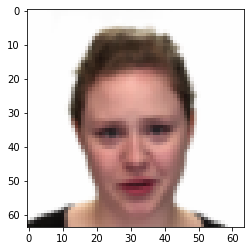

In [4]:
img = np.array(next(iter(face_dataset))['image']).transpose((1, 2, 0))
print(img.shape)
plt.imshow(img)

In [5]:
def emotion_rating_conversion(cat):
    ratings = torch.zeros(NUM_CLASSES)
    ratings[cat] = 1
    return ratings
    
#torch.argmax(emotion_rating_conversion(3))

In [6]:
# helper functions
class Swish(nn.Module):
    """https://arxiv.org/abs/1710.05941"""
    def forward(self, x):
        return x * torch.sigmoid(x)

def swish(x):
    return x * torch.sigmoid(x)

In [7]:
N_M = 0.125

class ProductOfExperts(nn.Module):
    """
    Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.

    @param loc: M x D for M experts
    @param scale: M x D for M experts
    """
    def forward(self, loc, scale, eps=1e-8):
        scale = scale + eps # numerical constant for stability
        # precision of i-th Gaussian expert (T = 1/sigma^2)
        T = 1. / scale
        product_loc = torch.sum(loc * T, dim=0) / torch.sum(T, dim=0)
        product_scale = 1. / torch.sum(T, dim=0)
        return product_loc, product_scale
      
class ImageEncoder(nn.Module):
    def __init__(self, z_dim=512, ch=32, scale=2):
        super(ImageEncoder, self).__init__()
        self.ch = ch
        
        # input = 64 * 64
        self.features = nn.Sequential(
            nn.Conv2d(3, ch, 3, 1, 1), nn.BatchNorm2d(ch), nn.ReLU(),
            nn.AvgPool2d(scale, scale), # 32
            nn.Conv2d(ch, ch * 2, 3, 1, 1), nn.BatchNorm2d(ch * 2), nn.ReLU(),
            nn.AvgPool2d(scale, scale), # 16
            nn.Conv2d(ch * 2, ch * 4, 3, 1, 1), nn.BatchNorm2d(ch * 4), nn.ReLU(),
            nn.AvgPool2d(scale, scale), # 8
            nn.Conv2d(ch * 4, ch * 8, 3, 1, 1), nn.BatchNorm2d(ch * 8), nn.ReLU(),
            nn.AvgPool2d(scale, scale), # 4
            nn.Conv2d(ch * 8, ch * 8, 3, 1, 1), nn.BatchNorm2d(ch * 8), nn.ReLU(),
            nn.AvgPool2d(scale, scale))# 2
                           
        self.z_loc_layer = nn.Sequential(
            nn.Linear(ch * 8 * 2 * 2, 512),
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim))
        
        self.z_scale_layer = nn.Sequential(
            nn.Linear(ch * 8 * 2 * 2, 512),
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, image):
        hidden = self.features(image)
        hidden = hidden.view(-1, self.ch * 8 * 2 * 2)  # it's 256 * 5 * 5 if input is 64x64.
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden)) #add exp so it's always positive
        return z_loc, z_scale
    
class ImageDecoder(nn.Module):
    def __init__(self, z_dim=512, ch=32, scale=2):
        super(ImageDecoder, self).__init__()
        
        self.ch = ch
        
        self.upsample = nn.Sequential(
            nn.Linear(z_dim, ch * 8 * 2 * 2),
            Swish())
        
        self.hallucinate = nn.Sequential(
            nn.ConvTranspose2d(ch * 8, ch * 8, 3, 1, 1), nn.BatchNorm2d(ch * 8), nn.ReLU(),
            nn.Upsample(scale_factor = scale, mode = "nearest"),
            nn.ConvTranspose2d(ch * 8, ch * 4, 3, 1, 1), nn.BatchNorm2d(ch * 4), nn.ReLU(),
            nn.Upsample(scale_factor = scale, mode = "nearest"),
            nn.ConvTranspose2d(ch * 4, ch * 2, 3, 1, 1), nn.BatchNorm2d(ch * 2), nn.ReLU(),
            nn.Upsample(scale_factor = scale, mode = "nearest"),
            nn.ConvTranspose2d(ch * 2, ch, 3, 1, 1), nn.BatchNorm2d(ch), nn.ReLU(),
            nn.Upsample(scale_factor = scale, mode = "nearest"),
            nn.ConvTranspose2d(ch, 3, 3, 1, 1),
            nn.Upsample(scale_factor = scale, mode = "nearest"))

    def forward(self, z):
        z = self.upsample(z)
        z = z.view(-1, self.ch * 8, 2, 2)
        image = self.hallucinate(z) # this is the image
        return image 

In [8]:
class EmotionEncoder(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|emotion category).
    This goes from ratings to the latent z

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim, use_cuda=True):
        super(EmotionEncoder, self).__init__()
        self.net = nn.Linear(NUM_CLASSES, 512)
        
        self.z_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        
        self.z_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, emocat):
        hidden = self.net(emocat)
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden))
        return z_loc, z_scale


class EmotionDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(emotion category|z).
    This goes from the latent z to the ratings

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(EmotionDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            Swish())
        
        self.emotion_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, NUM_CLASSES))
        
        self.emotion_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, NUM_CLASSES))

    def forward(self, z):
        #batch_size = z.size(0)
        hidden = self.net(z)
        emotion_loc = self.emotion_loc_layer(hidden)
        emotion_scale = torch.exp(self.emotion_scale_layer(hidden))
        # rating is going to be a |emotions| * 9 levels
        #rating = h.view(batch_size, EMOTION_VAR_DIM, 9)
        return emotion_loc, emotion_scale  # NOTE: no softmax here. See train.py

In [9]:
class MVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks), models & guides needed to train a
    multimodal variational auto-encoder.
    Modified from https://github.com/mhw32/multimodal-vae-public
    Multimodal Variational Autoencoder.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
                  
    Currently all the neural network dimensions are hard-coded; 
    in a future version will make them be inputs into the constructor
    """
    def __init__(self, z_dim, img_size=128, use_cuda=True):
        super(MVAE, self).__init__()
        self.z_dim = z_dim
        self.img_size = img_size
        self.experts = ProductOfExperts()
        self.image_encoder = ImageEncoder(z_dim, ch=64)
        self.image_decoder = ImageDecoder(z_dim, ch=64)
        self.emotion_encoder = EmotionEncoder(z_dim)
        self.emotion_decoder = EmotionDecoder(z_dim)
        
        self.use_cuda = use_cuda
        # relative weights of losses in the different modalities
        self.LAMBDA_IMAGES = 1.0
        self.LAMBDA_RATINGS = 50.0
        
        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()
            
    def model(self, images=None, emotions=None, annealing_beta=1.0):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("mvae", self)
        
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif emotions is not None:
            batch_size = emotions.size(0)
        
        with pyro.plate("data"):      
            # sample the latent z from the (constant) prior, z ~ Normal(0,I)
            z_prior_loc  = torch.zeros(size=[batch_size, self.z_dim])
            z_prior_scale = torch.exp(torch.zeros(size=[batch_size, self.z_dim]))     
            
            if self.use_cuda:
                z_prior_loc, z_prior_scale = z_prior_loc.cuda(), z_prior_scale.cuda()
            
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with poutine.scale(scale=annealing_beta):
                z = pyro.sample("z", dist.Normal(z_prior_loc, z_prior_scale))

            # decode the latent code z (image decoder)
            img_loc = self.image_decoder.forward(z)
            
            # score against actual images
            if images is not None:
                with poutine.scale(scale=self.LAMBDA_IMAGES):
                    #img_loc = (img_loc - torch.min(img_loc)) / (torch.max(img_loc) - torch.min(img_loc))
                    pyro.sample("obs_img", dist.Bernoulli(img_loc), obs=images)
            
            # decode the latent code z (emotion decoder)
            emotion_loc, emotion_scale = self.emotion_decoder.forward(z)
            if emotions is not None:
                with poutine.scale(scale=self.LAMBDA_RATINGS):
                    pyro.sample("obs_emotion", dist.Normal(emotion_loc, emotion_scale), obs=emotions)

            # return the loc so we can visualize it later
            return img_loc, emotion_loc
        
    def guide(self, images=None, emotions=None, annealing_beta=1.0):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("mvae", self)
        
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif emotions is not None:
            batch_size = emotions.size(0)
            
        with pyro.plate("data"):
            # use the encoder to get the parameters used to define q(z|x)
                        
            # initialize the prior expert.
            # we initalize an additional dimension, along which we concatenate all the 
            #   different experts.
            # self.experts() then combines the information from these different modalities
            #   by multiplying the gaussians together
            
            z_loc = torch.zeros(torch.Size((1, batch_size, self.z_dim))) + 0.5
            z_scale = torch.ones(torch.Size((1, batch_size, self.z_dim))) * 0.1
            
            if self.use_cuda:
                z_loc, z_scale = z_loc.cuda(), z_scale.cuda()
                
            if images is not None:
                image_z_loc, image_z_scale = self.image_encoder.forward(images)
                z_loc = torch.cat((z_loc, image_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, image_z_scale.unsqueeze(0)), dim=0)
            
            if emotions is not None:
                emotion_z_loc, emotion_z_scale = self.emotion_encoder.forward(emotions)
                z_loc = torch.cat((z_loc, emotion_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, emotion_z_scale.unsqueeze(0)), dim=0)
            
            z_loc, z_scale = self.experts(z_loc, z_scale)
            # sample the latent z
            with poutine.scale(scale=annealing_beta):
                pyro.sample("z", dist.Normal(z_loc, z_scale))
                
                
    def forward(self, image=None, emotion=None):
        z_loc, z_scale  = self.infer(image, emotion)
        z = pyro.sample("z", dist.Normal(z_loc, z_scale).independent(1))
        # reconstruct inputs based on that gaussian
        image_recon = self.image_decoder(z)
        rating_recon = self.emotion_decoder(z)
        return image_recon, rating_recon, z_loc, z_scale
    
    
    def infer(self, images=None, emotions=None):
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif emotions is not None:
            batch_size = emotions.size(0)
            
        # initialize the prior expert
        # we initalize an additional dimension, along which we concatenate all the 
        #   different experts.
        # self.experts() then combines the information from these different modalities
        #   by multiplying the gaussians together
        z_loc = torch.zeros(torch.Size((1, BATCH_SIZE, self.z_dim))) + 0.5
        z_scale = torch.ones(torch.Size((1, BATCH_SIXE, self.z_dim))) * 0.1
        
        if self.use_cuda:
            z_loc, z_scale = z_loc.cuda(), z_scale.cuda()

        if images is not None:
            image_z_loc, image_z_scale = self.image_encoder.forward(images)
            z_loc = torch.cat((z_loc, image_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, image_z_scale.unsqueeze(0)), dim=0)

        if emotions is not None:
            emotion_z_loc, emotion_z_scale = self.emotion_encoder.forward(emotions)
            z_loc = torch.cat((z_loc, emotion_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, emotion_z_scale.unsqueeze(0)), dim=0)

        z_loc, z_scale = self.experts(z_loc, z_scale)
        return z_loc, z_scale

    
    # define a helper function for reconstructing images
    def reconstruct_img(self, images):
        # encode image x
        z_loc, z_scale = self.image_encoder(images)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        img_loc = self.image_decoder.forward(z)
        return img_loc

    
    # define a helper function for reconstructing images without sampling
    def reconstruct_img_nosample(self, images):
        # encode image x
        z_loc, z_scale = self.image_encoder(images)
        ## sample in latent space
        #z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        img_loc = self.image_decoder.forward(z_loc)
        return img_loc

In [10]:
import gc

gc.collect()
torch.cuda.empty_cache()
pyro.clear_param_store()

class Args:
    learning_rate = 1e-4
    weight_decay = 1e-6
    num_epochs = 100 #500
    z_dim = DEFAULT_Z_DIM
    img_size = IMG_SIZE
    seed = 30
    cuda = True
    
args = Args()

# setup the optimizer
adam_args = {"lr": args.learning_rate, "weight_decay":args.weight_decay}
optimizer = Adam(adam_args)

# setup the VAE
mvae = MVAE(z_dim=args.z_dim, img_size=args.img_size, use_cuda=args.cuda)

# setup the inference algorithm
svi = SVI(mvae.model, mvae.guide, optimizer, loss=Trace_ELBO())

In [11]:
from tqdm import tqdm

train_elbo = []
# training loop
for epoch in tqdm(range(args.num_epochs)):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch returned
    # by the data loader
    for batch_num, sample in enumerate(dataset_loader):
                                  
        faces, emotions = sample['image'], sample['cat']
        emotions = torch.stack([emotion_rating_conversion(emo) for emo in emotions])
        
        # if on GPU put mini-batch into CUDA memory
        if args.cuda:
            faces, emotions = faces.cuda(), emotions.cuda()
        
        # do ELBO gradient and accumulate loss
        #print("Batch: ", batch_num, "out of", len(train_loader))
        epoch_loss += svi.step(images=faces, emotions=emotions)
        epoch_loss += svi.step(images=faces, emotions=None)
        epoch_loss += svi.step(images=None, emotions=emotions)

    # report training diagnostics
    normalizer_train = len(dataset_loader)
    total_epoch_loss_train = epoch_loss / normalizer_train
    train_elbo.append(total_epoch_loss_train)
    
    # report training diagnostics
    print("average training loss: %.4f" % (total_epoch_loss_train))

  1%|▎                         | 1/100 [01:39<2:44:40, 99.80s/it]

average training loss: 2401298.4752


  2%|▌                         | 2/100 [03:16<2:39:46, 97.82s/it]

average training loss: 633288.6877


  3%|▊                         | 3/100 [04:57<2:40:48, 99.47s/it]

average training loss: 636509.4426


  4%|█                         | 4/100 [06:38<2:39:46, 99.86s/it]

average training loss: 432567.2512


  5%|█▎                       | 5/100 [08:23<2:41:24, 101.94s/it]

average training loss: 556286.7922


  6%|█▌                       | 6/100 [10:05<2:39:48, 102.00s/it]

average training loss: 453001.8744


  7%|█▊                       | 7/100 [11:50<2:39:34, 102.95s/it]

average training loss: 295005.7324


  8%|██                        | 8/100 [13:18<2:30:25, 98.10s/it]

average training loss: 287013.3858


  9%|██▎                       | 9/100 [14:48<2:24:53, 95.54s/it]

average training loss: 210341.3557


 10%|██▌                      | 10/100 [16:28<2:25:36, 97.08s/it]

average training loss: 215391.5284


 11%|██▊                      | 11/100 [18:10<2:26:03, 98.47s/it]

average training loss: 179894.7341


 12%|███                      | 12/100 [19:49<2:24:46, 98.71s/it]

average training loss: 160837.9027


 13%|███                     | 13/100 [21:33<2:25:21, 100.25s/it]

average training loss: 146132.1267


 14%|███▎                    | 14/100 [23:16<2:24:53, 101.08s/it]

average training loss: 147085.5442


 15%|███▌                    | 15/100 [25:02<2:25:09, 102.46s/it]

average training loss: 126499.6444


 16%|███▊                    | 16/100 [26:45<2:23:52, 102.77s/it]

average training loss: 126098.7465


 17%|████                    | 17/100 [28:29<2:22:32, 103.04s/it]

average training loss: 116889.4422


 18%|████▎                   | 18/100 [30:11<2:20:27, 102.77s/it]

average training loss: 119704.6912


 19%|████▌                   | 19/100 [31:56<2:19:29, 103.33s/it]

average training loss: 117975.4256


 20%|████▊                   | 20/100 [33:40<2:18:17, 103.72s/it]

average training loss: 125179.3029


 21%|█████                   | 21/100 [35:25<2:17:06, 104.14s/it]

average training loss: 107597.9162


 22%|█████▎                  | 22/100 [37:13<2:16:41, 105.15s/it]

average training loss: 101264.3150


 23%|█████▌                  | 23/100 [38:58<2:14:53, 105.11s/it]

average training loss: 116867.4587


 24%|█████▊                  | 24/100 [40:42<2:12:44, 104.80s/it]

average training loss: 107875.9259


 25%|██████                  | 25/100 [42:21<2:08:57, 103.16s/it]

average training loss: 103090.8833


 26%|██████▏                 | 26/100 [44:04<2:07:01, 102.99s/it]

average training loss: 94652.8199


 27%|██████▍                 | 27/100 [45:52<2:07:15, 104.60s/it]

average training loss: 121481.4551


 28%|██████▋                 | 28/100 [47:45<2:08:17, 106.91s/it]

average training loss: 107932.9297


 29%|██████▉                 | 29/100 [49:38<2:08:48, 108.86s/it]

average training loss: 100289.2689


 30%|███████▏                | 30/100 [51:31<2:08:28, 110.12s/it]

average training loss: 93650.6849


 31%|███████▍                | 31/100 [53:25<2:07:57, 111.27s/it]

average training loss: 96632.2699


 32%|███████▋                | 32/100 [55:18<2:06:33, 111.67s/it]

average training loss: 87835.0175


 33%|███████▉                | 33/100 [57:10<2:04:52, 111.82s/it]

average training loss: 91056.4648


 34%|████████▏               | 34/100 [59:02<2:03:02, 111.86s/it]

average training loss: 90320.6253


 35%|███████▋              | 35/100 [1:00:51<2:00:14, 110.99s/it]

average training loss: 85912.6527


 36%|███████▉              | 36/100 [1:02:35<1:56:05, 108.84s/it]

average training loss: 80958.4146


 37%|████████▏             | 37/100 [1:04:19<1:52:58, 107.59s/it]

average training loss: 79666.4786


 38%|████████▎             | 38/100 [1:06:02<1:49:36, 106.08s/it]

average training loss: 75200.4371


 39%|████████▌             | 39/100 [1:07:46<1:47:09, 105.41s/it]

average training loss: 84136.9606


 40%|████████▊             | 40/100 [1:09:27<1:44:18, 104.30s/it]

average training loss: 81281.9562


 41%|█████████             | 41/100 [1:11:06<1:41:00, 102.72s/it]

average training loss: 73785.1732


 42%|█████████▏            | 42/100 [1:12:51<1:39:46, 103.22s/it]

average training loss: 73364.5927


 43%|█████████▍            | 43/100 [1:14:32<1:37:30, 102.64s/it]

average training loss: 73618.5739


 44%|█████████▋            | 44/100 [1:16:14<1:35:35, 102.41s/it]

average training loss: 70527.9913


 45%|█████████▉            | 45/100 [1:17:59<1:34:35, 103.19s/it]

average training loss: 70416.7979


 46%|██████████            | 46/100 [1:19:41<1:32:31, 102.81s/it]

average training loss: 67488.7036


 47%|██████████▎           | 47/100 [1:21:25<1:31:04, 103.10s/it]

average training loss: 64134.5603


 48%|██████████▌           | 48/100 [1:23:05<1:28:41, 102.33s/it]

average training loss: 66601.1153


 49%|██████████▊           | 49/100 [1:24:48<1:27:07, 102.50s/it]

average training loss: 69088.5842


 50%|███████████           | 50/100 [1:26:36<1:26:51, 104.23s/it]

average training loss: 63893.7011


 51%|███████████▏          | 51/100 [1:28:30<1:27:27, 107.10s/it]

average training loss: 66585.1237


 52%|███████████▍          | 52/100 [1:30:22<1:26:49, 108.53s/it]

average training loss: 60500.3721


 53%|███████████▋          | 53/100 [1:32:15<1:26:07, 109.95s/it]

average training loss: 67845.8970


 54%|███████████▉          | 54/100 [1:34:08<1:24:59, 110.86s/it]

average training loss: 68358.5926


 55%|████████████          | 55/100 [1:36:02<1:23:41, 111.58s/it]

average training loss: 61967.2494


 56%|████████████▎         | 56/100 [1:37:54<1:22:03, 111.89s/it]

average training loss: 60589.3462


 57%|████████████▌         | 57/100 [1:39:48<1:20:36, 112.48s/it]

average training loss: 62279.5620


 58%|████████████▊         | 58/100 [1:41:38<1:18:10, 111.69s/it]

average training loss: 65258.5013


 59%|████████████▉         | 59/100 [1:43:24<1:15:15, 110.12s/it]

average training loss: 61061.2427


 60%|█████████████▏        | 60/100 [1:45:09<1:12:20, 108.52s/it]

average training loss: 57671.4223


 61%|█████████████▍        | 61/100 [1:46:52<1:09:28, 106.88s/it]

average training loss: 55543.8506


 62%|█████████████▋        | 62/100 [1:48:39<1:07:40, 106.85s/it]

average training loss: 55600.9900


 63%|█████████████▊        | 63/100 [1:50:18<1:04:27, 104.53s/it]

average training loss: 63803.4925


 64%|██████████████        | 64/100 [1:52:05<1:03:05, 105.16s/it]

average training loss: 79267.2678


 65%|██████████████▎       | 65/100 [1:53:54<1:02:07, 106.50s/it]

average training loss: 61395.6084


 66%|██████████████▌       | 66/100 [1:55:42<1:00:38, 107.01s/it]

average training loss: 68564.1341


 67%|████████████████        | 67/100 [1:57:36<59:51, 108.82s/it]

average training loss: 57280.1146


 68%|████████████████▎       | 68/100 [1:59:26<58:16, 109.26s/it]

average training loss: 57708.3321


 69%|████████████████▌       | 69/100 [2:01:18<56:52, 110.06s/it]

average training loss: 63999.2426


 70%|████████████████▊       | 70/100 [2:03:11<55:31, 111.05s/it]

average training loss: 62806.4462


 71%|█████████████████       | 71/100 [2:05:04<54:00, 111.73s/it]

average training loss: 55286.5910


 72%|█████████████████▎      | 72/100 [2:06:58<52:22, 112.22s/it]

average training loss: 57033.1873


 73%|█████████████████▌      | 73/100 [2:08:41<49:15, 109.45s/it]

average training loss: 60192.3696


 74%|█████████████████▊      | 74/100 [2:10:30<47:27, 109.53s/it]

average training loss: 54688.7285


 75%|██████████████████      | 75/100 [2:12:24<46:05, 110.63s/it]

average training loss: 57524.3363


 76%|██████████████████▏     | 76/100 [2:14:16<44:27, 111.15s/it]

average training loss: 62741.1032


 77%|██████████████████▍     | 77/100 [2:16:08<42:40, 111.32s/it]

average training loss: 54519.4446


 78%|██████████████████▋     | 78/100 [2:18:00<40:52, 111.47s/it]

average training loss: 53218.2148


 79%|██████████████████▉     | 79/100 [2:19:51<39:02, 111.54s/it]

average training loss: 68433.7529


 80%|███████████████████▏    | 80/100 [2:21:47<37:38, 112.91s/it]

average training loss: 59163.3757


 81%|███████████████████▍    | 81/100 [2:23:44<36:04, 113.94s/it]

average training loss: 58034.6382


 82%|███████████████████▋    | 82/100 [2:25:39<34:18, 114.34s/it]

average training loss: 54461.1193


 83%|███████████████████▉    | 83/100 [2:27:33<32:20, 114.16s/it]

average training loss: 53766.6157


 84%|████████████████████▏   | 84/100 [2:29:23<30:09, 113.10s/it]

average training loss: 51924.4102


 85%|████████████████████▍   | 85/100 [2:31:16<28:15, 113.01s/it]

average training loss: 50766.8404


 86%|████████████████████▋   | 86/100 [2:33:08<26:16, 112.59s/it]

average training loss: 55260.4545


 87%|████████████████████▉   | 87/100 [2:34:59<24:19, 112.26s/it]

average training loss: 59200.8776


 88%|█████████████████████   | 88/100 [2:36:47<22:12, 111.04s/it]

average training loss: 62991.8784


 89%|█████████████████████▎  | 89/100 [2:38:29<19:49, 108.13s/it]

average training loss: 52647.8086


 90%|█████████████████████▌  | 90/100 [2:40:14<17:52, 107.22s/it]

average training loss: 53011.4328


 91%|█████████████████████▊  | 91/100 [2:41:48<15:30, 103.39s/it]

average training loss: 76789.6515


 92%|██████████████████████  | 92/100 [2:43:34<13:53, 104.19s/it]

average training loss: 53668.0232


 93%|██████████████████████▎ | 93/100 [2:45:21<12:13, 104.86s/it]

average training loss: 51181.5909


 94%|██████████████████████▌ | 94/100 [2:47:05<10:27, 104.53s/it]

average training loss: 50248.8809


 95%|██████████████████████▊ | 95/100 [2:48:49<08:42, 104.54s/it]

average training loss: 50899.5033


 96%|███████████████████████ | 96/100 [2:50:25<06:47, 101.92s/it]

average training loss: 48966.8278


 97%|███████████████████████▎| 97/100 [2:52:10<05:08, 102.99s/it]

average training loss: 47457.6360


 98%|███████████████████████▌| 98/100 [2:53:53<03:25, 102.71s/it]

average training loss: 51962.6581


 99%|███████████████████████▊| 99/100 [2:55:42<01:44, 104.85s/it]

average training loss: 48741.9096


100%|███████████████████████| 100/100 [2:57:35<00:00, 106.56s/it]

average training loss: 50669.1439


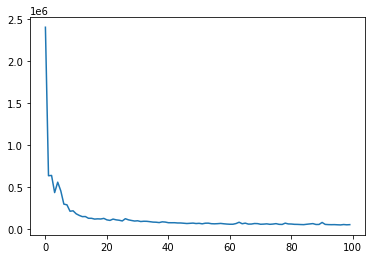

In [12]:
plt.plot(train_elbo)

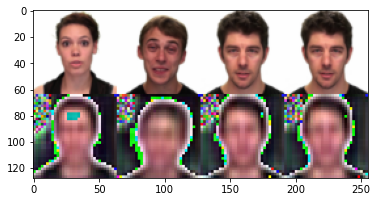

In [13]:
NUM_SAMPLES = 4
input_array = np.zeros(shape=(IMG_SIZE, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_SIZE, 1, 3), dtype="uint8")
    
# pick NUM_SAMPLES random test images from the first mini-batch and
# visualize how well we're reconstructing them

faces = next(iter(dataset_loader))['image']
if args.cuda:
    faces = faces.cuda()

reco_indices = np.random.randint(0, faces.size(0), NUM_SAMPLES)
for index in reco_indices:
    input_img = faces[index, :]
    # storing the input image
    input_img_display = np.array(input_img.cpu()*255., dtype='uint8')
    input_img_display = input_img_display.transpose((1, 2, 0))
    input_array = np.concatenate((input_array, input_img_display), axis=1)

    # generating the reconstructed image and adding to array
    input_img = input_img.view(1, 3, IMG_SIZE, IMG_SIZE)
    reconstructed_img = mvae.reconstruct_img_nosample(input_img)
    reconstructed_img = reconstructed_img.cpu().view(3, IMG_SIZE, IMG_SIZE).detach().numpy()
    reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
    reconstructed_img = reconstructed_img.transpose((1, 2, 0))
    reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

from PIL import Image

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
plt.imshow(display_array)

In [14]:
import os

# save model if you decide to modify the above code to train your own model
savemodel = True
if savemodel:
    if not os.path.exists('./trained_models'):
      os.mkdir('./trained_models')
    pyro.get_param_store().save('trained_models/mvae_pretrained.save')